In [1]:
import json
import emoji
import sys
import re
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


In [25]:
vocab_size = 18000
embedding_dim = 64
max_length = 120
filters = 100
kernel_size = 3
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8

In [3]:
emoji_list = emoji.UNICODE_EMOJI.keys()


In [4]:
with open('racism.json', 'r') as file:
    data_racism = pd.read_json(file,lines=True)
with open('neither.json', 'r') as file:
    data_neither = pd.read_json(file,lines=True)
with open('sexism.json', 'r') as file:
    data_sexism = pd.read_json(file,lines=True)
    

# labels = list(pd.Series(data['category']).str.lower())
# headlines = list(pd.Series(data['headline']).str.lower())

# for i in range(0,len(headlines)):
#     headline = headlines[i]
#     for word in stopwords:
#         token = " " + word + " "
#         headline = headline.replace(token, " ")
#     no_punct = ''
#     for char in headline:
#         if char not in punctuations:
#             no_punct = no_punct + char
#     headlines[i] = no_punct
# print(len(labels))
# print(len(headlines))
#print(headlines[0:100])

In [5]:
labels_read = []
text_read = []
labels_read = list(data_racism['Annotation'])
text_read = list(data_racism['text'])
labels_read.extend(list(data_neither['Annotation']))
labels_read.extend(list(data_sexism['Annotation']))
text_read.extend(list(data_neither['text']))
text_read.extend(list(data_sexism['text']))

print(len(text_read))

16907


In [6]:
labels = list()
texts = list()
i = 0
for i in range(0,len(text_read)):
    labels.append(labels_read[i])
    texts.append(text_read[i])
print(type(text_read[i]))
print(len(texts))
print(len(labels))

<class 'str'>
16907
16907


In [7]:
FLAGS = re.MULTILINE | re.DOTALL

# def hashtag(text):
#     text = text.group()
#     hashtag_body = text[1:]
#     if hashtag_body.isupper():
#         result = u"<hashtag> {} <allcaps>".format(hashtag_body)
#     else:
#         result = " ".join(["<hashtag>"] + re.split(ur"(?=[A-Z])", hashtag_body, flags=FLAGS))
#     return result

def allcaps(text):
    text = text.group()
    return text.lower() + " <allcaps>"


def preprocess(text):
    # Different regex parts for smiley faces
    # function so code less repetitive
    def re_sub(pattern, repl):
        return re.sub(pattern, repl, text, flags=FLAGS)
    
    text = text.replace("#","<hashtag> ")
    
#     words = text.split(' ')
#     for i in range(0, len(words)):
#         word = words[i]
#         if word in emoji_list:
#             words[i] = '<'+emoji.demojize(word)+'>'
#     text = ' '.join([str(elem) for elem in words]) 
    
    no_punct = ''
    for char in text:
        if char not in emoji_list:
            no_punct = no_punct + char
        else:
            no_punct = no_punct + '<' + emoji.demojize(char) + '> '
    text = no_punct
    
    
#     eyes = r"[8:=;]"
#     nose = r"['`\-]?"
#     text = re_sub(r"{}{}[)dD]+|[)dD]+{}{}".format(eyes, nose, nose, eyes), "<smile>")
#     text = re_sub(r"{}{}p+".format(eyes, nose), "<lolface>")
#     text = re_sub(r"{}{}\(+|\)+{}{}".format(eyes, nose, nose, eyes), "<sadface>")
#     text = re_sub(r"{}{}[\/|l*]".format(eyes, nose), "<neutralface>")
#     text = re_sub(r"<3","<heart>")
    
    
    text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "<url>")
    text = re_sub(r"/"," / ")
    text = re_sub(r"([!?.]){2,}", r"\1 <repeat>")
    text = re_sub(r"\b(\S*?)(.)\2{2,}\b", r"\1\2 <elong>")

    ## -- I just don't understand why the Ruby script adds <allcaps> to everything so I limited the selection.
    # text = re_sub(r"([^a-z0-9()<>'`\-]){2,}", allcaps)
    text = re_sub(r"([A-Z]){2,}", allcaps)
    
    punctuations = '''!()-[]{};:'"\,./?@#$%^&*_~0123456789'''
    
    no_punct = ''
    for char in text:
        if char not in punctuations:
            no_punct = no_punct + char
    text = no_punct

    return text.lower()


In [8]:
for i in range(0, len(texts)):
    texts[i] = preprocess(texts[i])

In [9]:
print(preprocess('hello hello arunima randi ki bachchi chutiya saali 😄😄'))

hello hello arunima randi ki bachchi chutiya saali <grinningfacewithsmilingeyes> <grinningfacewithsmilingeyes> 


In [10]:
print(texts[2213])

its gonna a girls round on <hashtag> mkr this week but idc bcuz its time for <hashtag> revenge amp lr <hashtag> sleepyhollow amp <hashtag> elementary <kissmark> <speechballoon> <facesavoringfood> <sparkles> <peoplewithbunnyears> <cooking> <television> <warning> ️


In [11]:
print(set(labels))

{'none', 'sexism', 'racism'}


In [13]:
train_tweets, validation_tweets, train_labels, validation_labels = train_test_split(texts, labels, test_size=0.2)
print(len(train_tweets))
print(len(train_labels))
print(len(validation_tweets))
print(len(validation_labels))



13525
13525
3382
3382


In [16]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(train_tweets)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_tweets)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length, truncating=trunc_type)

print(word_index)
print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

{'<OOV>': 1, 'allcaps': 2, 'hashtag': 3, 'the': 4, 'mkr': 5, 'to': 6, 'a': 7, 'i': 8, 'and': 9, 'is': 10, 'of': 11, 'rt': 12, 'you': 13, 'that': 14, 'url': 15, 'in': 16, 'not': 17, 'are': 18, 'repeat': 19, 'it': 20, 'but': 21, 'for': 22, 'they': 23, 'on': 24, 'this': 25, 'im': 26, 'be': 27, 'have': 28, 'with': 29, 'just': 30, 'no': 31, 'sexist': 32, 'kat': 33, 'so': 34, 'about': 35, 'like': 36, 'me': 37, 'my': 38, 'its': 39, 'all': 40, 'was': 41, 'your': 42, 'if': 43, 'what': 44, 'dont': 45, 'women': 46, 'islam': 47, 'do': 48, 'at': 49, 'as': 50, 'by': 51, 'can': 52, 'people': 53, 'from': 54, 'we': 55, 'or': 56, 'amp': 57, 'get': 58, 'their': 59, 'one': 60, 'up': 61, 'there': 62, 'how': 63, 'when': 64, 'them': 65, 'more': 66, 'will': 67, 'an': 68, '…': 69, 'who': 70, 'andre': 71, 'out': 72, 'think': 73, 'would': 74, 'has': 75, 'isis': 76, 'why': 77, 'elong': 78, 'because': 79, 'girls': 80, 'muslims': 81, 'now': 82, 'he': 83, 'cant': 84, 'know': 85, 'should': 86, 'go': 87, 'want': 88, '

In [18]:
validation_sequences = tokenizer.texts_to_sequences(validation_tweets)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

3382
(3382, 120)


In [19]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

padded_validation_label_seq = pad_sequences(validation_label_seq, padding=padding_type, maxlen=1, truncating=trunc_type)
train_lables_padded = pad_sequences(training_label_seq, padding=padding_type, maxlen=1, truncating=trunc_type)

category_word_index = label_tokenizer.word_index

In [47]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
#     tf.keras.layers.LSTM(150, return_sequences = True),
#     tf.keras.layers.LSTM(300),
#     tf.keras.layers.GRU(300),
#     tf.keras.layers.SimpleRNN(100, activation='tanh', return_sequences = True),
#     tf.keras.layers.SimpleRNN(200, activation='relu'),
    
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation = 'sigmoid'),
    tf.keras.layers.Dense(4, activation = 'softmax')
])

model.compile(loss = 'sparse_categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(lr=0.0006), metrics=['acc'])
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 120, 64)           1152000   
_________________________________________________________________
dropout_12 (Dropout)         (None, 120, 64)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 118, 100)          19300     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 59, 100)           0         
_________________________________________________________________
global_average_pooling1d_11  (None, 100)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 24)                2424      
_________________________________________________________________
dense_30 (Dense)             (None, 4)               

In [48]:
num_epochs = 8
history = model.fit(train_padded, train_lables_padded, epochs = num_epochs, validation_data=(validation_padded, padded_validation_label_seq), verbose = 2)

Train on 13525 samples, validate on 3382 samples
Epoch 1/8
13525/13525 - 17s - loss: 0.8580 - acc: 0.6642 - val_loss: 0.7298 - val_acc: 0.7200
Epoch 2/8
13525/13525 - 16s - loss: 0.6204 - acc: 0.7556 - val_loss: 0.5822 - val_acc: 0.7759
Epoch 3/8
13525/13525 - 16s - loss: 0.4930 - acc: 0.8223 - val_loss: 0.4974 - val_acc: 0.8235
Epoch 4/8
13525/13525 - 16s - loss: 0.3731 - acc: 0.8751 - val_loss: 0.4357 - val_acc: 0.8459
Epoch 5/8
13525/13525 - 16s - loss: 0.2822 - acc: 0.9024 - val_loss: 0.4062 - val_acc: 0.8513
Epoch 6/8
13525/13525 - 16s - loss: 0.2155 - acc: 0.9279 - val_loss: 0.4071 - val_acc: 0.8465
Epoch 7/8
13525/13525 - 16s - loss: 0.1671 - acc: 0.9449 - val_loss: 0.4103 - val_acc: 0.8530
Epoch 8/8
13525/13525 - 16s - loss: 0.1342 - acc: 0.9556 - val_loss: 0.4218 - val_acc: 0.8525


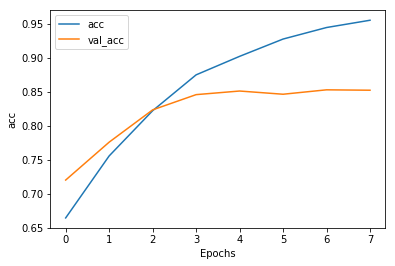

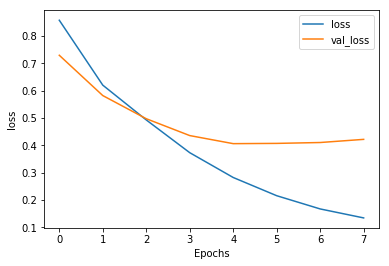

In [50]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):

  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "acc")
plot_graphs(history, "loss")